- 나눔글꼴 설치 및 적용
    - 설치 후 런타임 재시작 필요

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,517 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and dire

- 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 서드파티 모듈 설치

In [ ]:
!pip install konlpy
!pip install mecab-python
!apt-get install -y openjdk-8-jdk
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 34.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 9.1 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1231 sha256=ceeaf9f43b02b05b3740743462abd68ee73b100dd96f01f02ffb98b6860f61ec
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libice-dev librsvg2-common
  libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-8-jdk-h

# [1] 모듈 로드

In [ ]:
import os
import sys
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import re

import warnings

plt.rc('font', family='NanumBarunGothic')
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.metrics import silhouette_score
from tabulate import tabulate

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from konlpy.tag import Mecab
from konlpy.tag import Kkma
from konlpy.utils import pprint



%matplotlib inline

# [2] 데이터 로드

- bank_info_df : 은행 기초재무정보주요경영지표
- dp_df : 은행/저축은행 예금상품 전체

In [ ]:
bank_info_df = pd.read_excel('/content/drive/MyDrive/ASAC/최종프로젝트_우리만/이한석/data/(저축)은행_기초재무정보주요경영지표.xlsx')
dp_df = pd.read_csv('/content/drive/MyDrive/ASAC/최종프로젝트_우리만/이한석/data/deposit_all.csv', encoding = 'utf-8')

In [ ]:
bank_info_df.shape, dp_df.shape

((100, 10), (740, 32))

In [ ]:
bank_info_df

,구분,총자산,총부채,자기자본,당기순이익,BIS비율,여신비율,ROA,NIM,유형
0,경남은행,49459933,45969835,3490097,179759,14.63,0.37,0.60,1.90,은행
1,광주은행,28586391,26404717,2181674,153747,15.69,0.45,0.88,2.89,은행
2,국민은행,506394830,471771786,34623044,2318601,18.45,0.25,0.60,1.82,은행
3,농협은행주식회사,392192577,369969859,22222718,1512360,18.67,0.29,0.46,1.98,은행
4,대구은행,68723045,63714954,5008091,286461,17.65,0.58,0.56,2.04,은행
...,...,...,...,...,...,...,...,...,...,...
95,한국투자저축은행,8611067,7403931,1207136,3129,16.30,4.35,1.04,NaN,저축은행
96,한성저축은행,397475,332131,65344,-1994,22.12,7.55,1.58,NaN,저축은행
97,한화저축은행,1754102,1579621,174481,4911,13.13,4.78,1.39,NaN,저축은행
98,흥국저축은행,516818,445217,71601,3529,16.97,3.13,1.74,NaN,저축은행


In [ ]:
dp_df.head(5)

,금융회사,상품명,이자계산방식,세전이자율_6,세후이자율_6,최고우대금리_6,세전이자율_12,세후이자율_12,최고우대금리_12,세전이자율_24,...,우대조건_12,우대조건_24,우대조건_36,가입방법,만기후 이자율_6,만기후 이자율_12,만기후 이자율_24,만기후 이자율_36,기타유의사항,은행_상품_계산
0,페퍼저축은행,정기예금,복리,2.80%,2.37%,2.80%,4.00%,3.38%,4.00%,3.20%,...,우대사항없음,우대사항없음,우대사항없음,영업점,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,최소가입금액: 10만원 이상,페퍼저축은행_정기예금_복리
1,인천저축은행,e-보다 회전정기예금,복리,NaN,NaN,NaN,4.20%,3.55%,4.20%,NaN,...,인터넷뱅킹 전용상품,NaN,NaN,"인터넷,스마트폰",NaN,*만기후 1개월이내 : 마지막 만기주기의 약정이율\n*만기 1개월이후 : 연0.1%,NaN,NaN,예금가입금액 10만원이상,인천저축은행_e-보다 회전정기예금_복리
2,머스트삼일저축은행,자유적립예금,단리,1.00%,0.85%,1.00%,1.60%,1.35%,1.60%,1.60%,...,없음,없음,없음,영업점,- 만기후 1개월 이내 : 1.2%\n- 만기후 1개월 초과 : 연0.2%,- 만기후 1개월 이내 : 1.2%\n- 만기후 1개월 초과 : 연0.2%,- 만기후 1개월 이내 : 1.2%\n- 만기후 1개월 초과 : 연0.2%,- 만기후 1개월 이내 : 1.2%\n- 만기후 1개월 초과 : 연0.2%,없음,머스트삼일저축은행_자유적립예금_단리
3,대원저축은행,정기예금,단리,2.20%,1.86%,2.20%,3.60%,3.05%,3.60%,2.70%,...,-없음,-없음,-없음,영업점,- 만기후 1개월 이내 : 가입당시 약정금리 적용\n- 만기후 1개월 초과 : 보통...,- 만기후 1개월 이내 : 가입당시 약정금리 적용\n- 만기후 1개월 초과 : 보통...,- 만기후 1개월 이내 : 가입당시 약정금리 적용\n- 만기후 1개월 초과 : 보통...,- 만기후 1개월 이내 : 가입당시 약정금리 적용\n- 만기후 1개월 초과 : 보통...,"1. 최소금액 : 10만원 이상\n2. 1인당 가입금액 한도 : 4,820만원",대원저축은행_정기예금_단리
4,세람저축은행,정기예금,복리,3.00%,2.54%,3.00%,3.90%,3.30%,3.90%,2.40%,...,없음,없음,없음,영업점,1개월내 : 약정금리와 해당 계약기간의 현행금리 중 낮은 금리 \n1개월 초과: 보...,1개월내 : 약정금리와 해당 계약기간의 현행금리 중 낮은 금리 \n1개월 초과: 보...,1개월내 : 약정금리와 해당 계약기간의 현행금리 중 낮은 금리 \n1개월 초과: 보...,1개월내 : 약정금리와 해당 계약기간의 현행금리 중 낮은 금리 \n1개월 초과: 보...,없음,세람저축은행_정기예금_복리


In [ ]:
dp_bank_df = dp_df.merge(bank_info_df, left_on = '금융회사', right_on = '구분', how = 'left')
dp_bank_df.head()

,금융회사,상품명,이자계산방식,세전이자율_6,세후이자율_6,최고우대금리_6,세전이자율_12,세후이자율_12,최고우대금리_12,세전이자율_24,...,구분,총자산,총부채,자기자본,당기순이익,BIS비율,여신비율,ROA,NIM,유형
0,페퍼저축은행,정기예금,복리,2.80%,2.37%,2.80%,4.00%,3.38%,4.00%,3.20%,...,페퍼저축은행,6386109.0,5888658.0,497451.0,-42928.0,11.53,7.33,0.80,NaN,저축은행
1,인천저축은행,e-보다 회전정기예금,복리,NaN,NaN,NaN,4.20%,3.55%,4.20%,NaN,...,인천저축은행,529550.0,459287.0,70263.0,2071.0,15.43,5.37,1.48,NaN,저축은행
2,머스트삼일저축은행,자유적립예금,단리,1.00%,0.85%,1.00%,1.60%,1.35%,1.60%,1.60%,...,머스트삼일저축은행,241321.0,222283.0,19038.0,2693.0,10.55,2.40,1.72,NaN,저축은행
3,대원저축은행,정기예금,단리,2.20%,1.86%,2.20%,3.60%,3.05%,3.60%,2.70%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,세람저축은행,정기예금,복리,3.00%,2.54%,3.00%,3.90%,3.30%,3.90%,2.40%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# [3] 텍스트 분석 기반 군집분석

In [ ]:
dp_df.head(2)

,금융회사,상품명,이자계산방식,세전이자율_6,세후이자율_6,최고우대금리_6,세전이자율_12,세후이자율_12,최고우대금리_12,세전이자율_24,...,우대조건_12,우대조건_24,우대조건_36,가입방법,만기후 이자율_6,만기후 이자율_12,만기후 이자율_24,만기후 이자율_36,기타유의사항,은행_상품_계산
0,페퍼저축은행,정기예금,복리,2.80%,2.37%,2.80%,4.00%,3.38%,4.00%,3.20%,...,우대사항없음,우대사항없음,우대사항없음,영업점,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,* 만기 후 1개월 이내 기간 : 당초 약정금리 또는 만기시 동일상품 동일계약기간의...,최소가입금액: 10만원 이상,페퍼저축은행_정기예금_복리
1,인천저축은행,e-보다 회전정기예금,복리,NaN,NaN,NaN,4.20%,3.55%,4.20%,NaN,...,인터넷뱅킹 전용상품,NaN,NaN,"인터넷,스마트폰",NaN,*만기후 1개월이내 : 마지막 만기주기의 약정이율\n*만기 1개월이후 : 연0.1%,NaN,NaN,예금가입금액 10만원이상,인천저축은행_e-보다 회전정기예금_복리


## 3-1. 전처리

- NA 처리 : 현재의 NA값들은 존재하지 않는 값임. 텍스트 분석을 위해 '해당 없음'으로 우선 대체한다.

In [ ]:
dp_bank_df = dp_bank_df.fillna('해당없음')

- 이자계산방식, 우대조건, 가입방법, 기타유의사항 4개 칼럼을 병합한다.

In [ ]:
#dp_bank_df['text_for_cl'] = dp_bank_df['우대조건_6'] + ' ' + dp_bank_df['우대조건_12'] + ' ' + dp_bank_df['우대조건_24'] + ' ' + dp_bank_df['우대조건_36'] + ' ' + dp_bank_df['가입방법'] #+ ' ' + dp_bank_df['기타유의사항']

In [ ]:
def check_columns_equal(df, columns):
    # columns 리스트 안의 칼럼들의 값이 모두 같은지 확인
    return all(df[column].equals(df[columns[0]]) for column in columns[1:])

# 원하는 칼럼들
target_columns = ['우대조건_6', '우대조건_12', '우대조건_24', '우대조건_36']

# 칼럼 값이 모두 같은 경우에만 한 칼럼으로 대체
if check_columns_equal(dp_bank_df, target_columns):
    dp_bank_df['text_for_cl'] = dp_bank_df[target_columns[0]]
else:
    # 모두 같지 않다면 기존과 동일하게 합치기
    dp_bank_df['text_for_cl'] = dp_bank_df['우대조건_6'] + ' ' + dp_bank_df['우대조건_12'] + ' ' + dp_bank_df['우대조건_24'] + ' ' + dp_bank_df['우대조건_36'] + ' ' + dp_bank_df['가입방법'] + ' ' + dp_bank_df['기타유의사항']

In [ ]:
dp_bank_df['text_for_cl']

0        우대사항없음 우대사항없음 우대사항없음 우대사항없음 영업점 최소가입금액: 10만원 이상
1       해당없음 인터넷뱅킹 전용상품 해당없음 해당없음 인터넷,스마트폰 예금가입금액 10만원이상
2                                     없음 없음 없음 없음 영업점 없음
3      -없음 -없음 -없음 -없음 영업점 1. 최소금액 : 10만원 이상\n2. 1인당 ...
4                                     없음 없음 없음 없음 영업점 없음
                             ...                        
735    없음 없음 해당없음 해당없음 인터넷,스마트폰 -1인 다계좌 가능.\n 단, 합산금액...
736                        해당없음 해당없음 해당없음 - 영업점 영업점 전용상품
737    해당없음 없음 없음 없음 스마트폰 *OK저축은행 모바일뱅킹앱 전용상품\n*3년제 정...
738    없음 해당없음 없음 없음 인터넷 - 이자지급방식 : 단리식(매월지급), 복리식(만기...
739    해당없음 *회전시점 고시된 12개월 정기예금금리 + 우대금리 0.1%로 자동연장되는...
Name: text_for_cl, Length: 740, dtype: object

## 3-2 텍스트 분석

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 31.1 MB/s eta 0:00:00


In [ ]:
!pip install mecab-python
!apt-get install -y openjdk-8-jdk
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-8-jdk is already the newest version (8u382-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


- 전처리 (불용어 처리)

In [ ]:
# 불용어(stopwords) 처리
stopwords = ['해당', '없음','개월', '사항']

# 텍스트 데이터 가져오기
texts = dp_bank_df['text_for_cl']

- 명사 추출
    - 각 text를 가져와서
    - kkma를 이용해 명사를 추출하고
    - 추출된 명사에서 불용어를 제거한 후
    - 추출된 명사들을 하나의 문자열로 합쳐 리스트에 추가한다

In [ ]:
# Konlpy의 Kkma를 이용하여 명사 추출
#kkma = Kkma()
mecab = Mecab()

tokenized_texts = []

for text in texts:
    nouns = [noun for noun in mecab.nouns(text) if noun not in stopwords]
    tokenized_texts.append(' '.join(nouns))

In [ ]:
tokenized_texts

['우대 우대 우대 우대 영업 점 최소 입금액 만 원 이상',
 '인터넷 뱅킹 전용 상품 인터넷 스마트폰 예금 가입 금액 만 원 이상',
 '영업 점',
 '영업 점 최소 금액 만 원 이상 인 가입 금액 한도 만 원',
 '영업 점',
 '영업 점',
 '인터넷',
 '인터넷 스마트폰',
 '최고 항목 급여 이체 립식 예금 잔액 만 원 이상 보유 탑스 주 거래 고객 결제 계좌 가맹점 전월 입금액 만 원 이상 과세 종합 저축 대상 고객 다자녀 인 이상 자녀 가정 연금 통장 가입 고객 국민 연금 안심 통장 가입 고객 공무원 연금 안심 통장 가입 고객 최고 항목 급여 이체 립식 예금 잔액 만 원 이상 보유 탑스 주 거래 고객 결제 계좌 가맹점 전월 입금액 만 원 이상 과세 종합 저축 대상 고객 다자녀 인 이상 자녀 가정 연금 통장 가입 고객 국민 연금 안심 통장 가입 고객 공무원 연금 안심 통장 가입 고객 최고 항목 급여 이체 립식 예금 잔액 만 원 이상 보유 탑스 주 거래 고객 결제 계좌 가맹점 전월 입금액 만 원 이상 과세 종합 저축 대상 고객 다자녀 인 이상 자녀 가정 연금 통장 가입 고객 국민 연금 안심 통장 가입 고객 공무원 연금 안심 통장 가입 고객 최고 항목 급여 이체 립식 예금 잔액 만 원 이상 보유 탑스 주 거래 고객 결제 계좌 가맹점 전월 입금액 만 원 이상 과세 종합 저축 대상 고객 다자녀 인 이상 자녀 가정 연금 통장 가입 고객 국민 연금 안심 통장 가입 고객 공무원 연금 안심 통장 가입 고객 영업 점 가입 금액 백만 원 이상',
 '스마트폰 실제 예치기 간별 차등 금리 미만 세전 미만 약정 율 미만 약정 율 미만 약정 율 이상 미만 약정 율',
 '영업 점',
 '영업 점 최소 입금액 만 원 이상 정기예금 초과 정기예금 적용',
 '스마트폰 복 리식 상품 개설 시 계약 기간 입력 입력 중도 지이 미만 이상 이상 이상 이상',
 '영업 점 상품 최초 가입 일자 년 경과 해지 경우 금번 금리 변경 일자 약정 적용 금번 금리 변경 일 이후 년 중도

- TF-IDF 벡터화


In [ ]:
vectorizer = TfidfVectorizer()
tf_idf_data = vectorizer.fit_transform(tokenized_texts)

In [ ]:
tf_idf_data.toarray().shape

(740, 337)

## 3-3. K-means 군집 분석

- 최적 K 도출

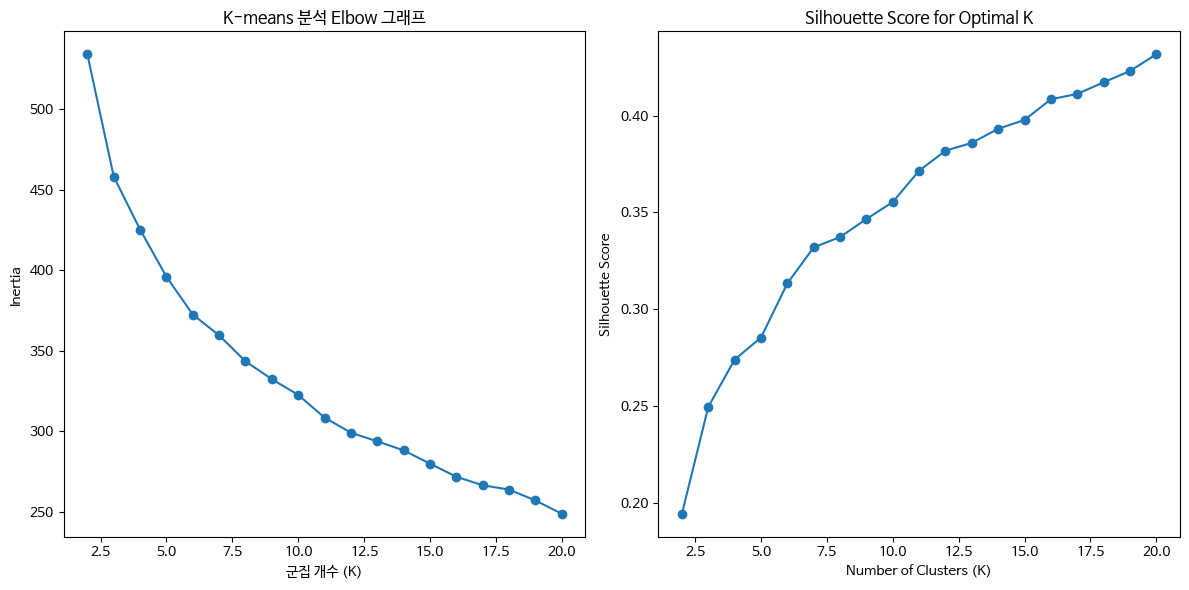

In [ ]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tf_idf_data = vectorizer.fit_transform(tokenized_texts)

# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tf_idf_data)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(tf_idf_data, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(tf_idf_data)

# 클러스터 결과를 데이터프레임에 추가
dp_bank_df['cluster'] = kmeans.labels_

- 군집별 갯수 확인

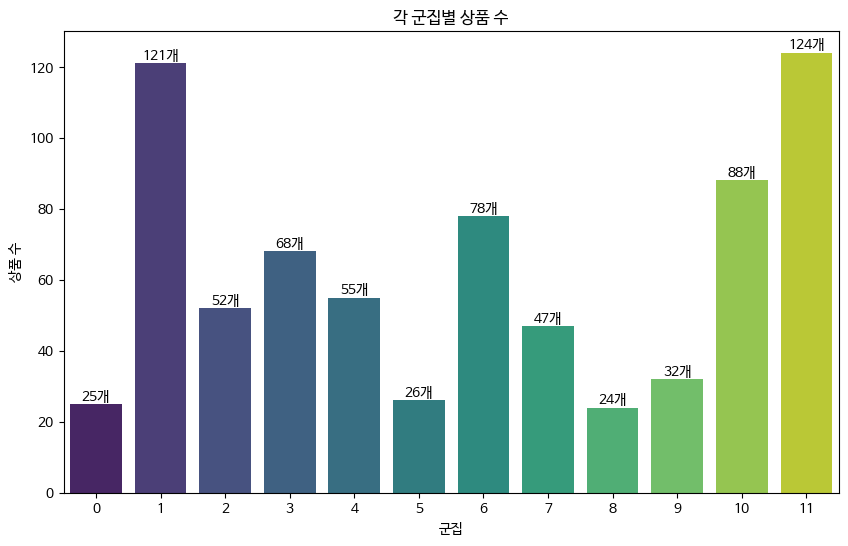

In [ ]:
df = dp_bank_df.groupby(['cluster']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster', y='상품명', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

- 각 군집의 중심 및 핵심 구분단어 확인

In [ ]:
cluster_centers = kmeans.cluster_centers_

# 각 군집의 중심에서 가장 가까운 단어 20개씩 추출
top_words_per_cluster = []
for center in cluster_centers:
    # 각 군집의 중심에서 가까운 10개 단어씩 가져오기
    top_word_indices = center.argsort()[-10:][::-1]

    # 해당 인덱스에 해당하는 단어들을 리스트에 추가
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_word_indices]
    top_words_per_cluster.append(top_words)

# 각 군집의 중심에서 가장 가까운 단어 출력
for i, top_words in enumerate(top_words_per_cluster):
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: 가능, 과세, 종합, 저축, 이상, 가입, 스마트폰, 인터넷, 사용, 시간
Cluster 2: 영업, 점전, 상품, 전용, 가입, 인터넷, 봉사, 별도, 보너스, 보유
Cluster 3: 금리, 시점, 회전, 연장, 적용, 중도, 자동, 확정, 이율, 정기
Cluster 4: 미만, 약정, 이상, 계약, 중도, 보통, 예금, 이율, 금리, 지이
Cluster 5: 전용, 상품, 인터넷, 뱅킹, 가입, 스마트폰, 창구, 모바일, 제한, 스마트
Cluster 6: 금액, 이상, 가입, 최소, 스마트폰, 인터넷, 영업, 창구, 한도, 가족
Cluster 7: 회전, 주기, 변동, 금리, 기간, 약정, 가입, 상품, 적용, 계약
Cluster 8: 스마트폰, 전용, 봉사, 변동, 별도, 보너스, 보유, 보통, 보호, 보호법
Cluster 9: 자율, 회전, 미만, 도래, 주기, 적용, 세전, 중도, 약정, 잔여
Cluster 10: 우대, 이상, 최소, 입금액, 재예, 적금, 만기, 조건, 원금, 가입
Cluster 11: 인터넷, 스마트폰, 영업, 전용, 가입, 휴일, 보호법, 변동, 별도, 보너스
Cluster 12: 이상, 적용, 인터넷, 입금액, 가입, 정기예금, 금리, 한도, 우대금리, 최소


## 3-4. 군집별 특징 확인

In [ ]:
dp_bank_df

,금융회사,상품명,이자계산방식,세전이자율_6,세후이자율_6,최고우대금리_6,세전이자율_12,세후이자율_12,최고우대금리_12,세전이자율_24,...,총부채,자기자본,당기순이익,BIS비율,여신비율,ROA,NIM,유형,text_for_cl,cluster
0,페퍼저축은행,정기예금,복리,2.80%,2.37%,2.80%,4.00%,3.38%,4.00%,3.20%,...,5888658.0,497451.0,-42928.0,11.53,7.33,0.8,해당없음,저축은행,우대사항없음 우대사항없음 우대사항없음 우대사항없음 영업점 최소가입금액: 10만원 이상,9
1,인천저축은행,e-보다 회전정기예금,복리,해당없음,해당없음,해당없음,4.20%,3.55%,4.20%,해당없음,...,459287.0,70263.0,2071.0,15.43,5.37,1.48,해당없음,저축은행,"해당없음 인터넷뱅킹 전용상품 해당없음 해당없음 인터넷,스마트폰 예금가입금액 10만원이상",4
2,머스트삼일저축은행,자유적립예금,단리,1.00%,0.85%,1.00%,1.60%,1.35%,1.60%,1.60%,...,222283.0,19038.0,2693.0,10.55,2.4,1.72,해당없음,저축은행,없음 없음 없음 없음 영업점 없음,1
3,대원저축은행,정기예금,단리,2.20%,1.86%,2.20%,3.60%,3.05%,3.60%,2.70%,...,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,-없음 -없음 -없음 -없음 영업점 1. 최소금액 : 10만원 이상\n2. 1인당 ...,5
4,세람저축은행,정기예금,복리,3.00%,2.54%,3.00%,3.90%,3.30%,3.90%,2.40%,...,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,없음 없음 없음 없음 영업점 없음,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,수협은행,헤이(Hey)정기예금,단리,4.20%,3.55%,4.20%,4.30%,3.64%,4.30%,해당없음,...,52373776.0,3662503.0,142852.0,13.62,0.46,0.41,1.58,은행,"없음 없음 해당없음 해당없음 인터넷,스마트폰 -1인 다계좌 가능.\n 단, 합산금액...",11
736,웰컴저축은행,웰뱅 회전 정기예금,복리,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,...,5990321.0,712254.0,23823.0,14.07,7.58,1.37,해당없음,저축은행,해당없음 해당없음 해당없음 - 영업점 영업점 전용상품,1
737,OK저축은행,OK e-안심앱플러스정기예금(변동금리),단리,해당없음,해당없음,해당없음,4.31%,3.65%,4.31%,4.31%,...,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음,해당없음 없음 없음 없음 스마트폰 *OK저축은행 모바일뱅킹앱 전용상품\n*3년제 정...,2
738,신한저축은행,e-정기예금,복리,3.00%,2.54%,3.00%,해당없음,해당없음,해당없음,1.80%,...,2783813.0,305373.0,10041.0,16.03,3.02,1.53,해당없음,저축은행,"없음 해당없음 없음 없음 인터넷 - 이자지급방식 : 단리식(매월지급), 복리식(만기...",11


In [ ]:
dp_bank_df['tokenized_texts'] = tokenized_texts
dp_bank_df.tokenized_texts

0                         우대 우대 우대 우대 영업 점 최소 입금액 만 원 이상
1                  인터넷 뱅킹 전용 상품 인터넷 스마트폰 예금 가입 금액 만 원 이상
2                                                   영업 점
3                       영업 점 최소 금액 만 원 이상 인 가입 금액 한도 만 원
4                                                   영업 점
                             ...                        
735           인터넷 스마트폰 인 계좌 가능 합산 금액 최대 억 원 이내 최저 만 원 이상
736                                      영업 점 영업 점 전용 상품
737    스마트폰 저축 은행 모바일 뱅킹 앱 전용 상품 년 정기 예금 가입 후 매 년 시점 ...
738    인터넷 지급 방식 리식 매월 지급 복 리식 만기 일시 지급 가입 방법 인터넷 홈페이...
739    회전 시점 고시 정기 예금 금리 우대금리 자동 연장 변동 금리 상품 년 단위 확정 ...
Name: tokenized_texts, Length: 740, dtype: object

## 3-5. 군집 확인

- 군집 0 : 만원 이상 가입 가능한 조건이 있다.
- 군집 1 : 영업점 방문 전용 상품이다.
- 군집 2 : 금리 변동이 있는 상품이다.
- 군집 3 :
- 군집 4 :
- 군집 5 :
- 군집 6 :
- 군집 7 : 스마트폰 전용 상품이다.
- 군집 8 :
- 군집 9 :
- 군집 10 :
- 군집 11 :
- 군집 12 :

In [ ]:
def cutthe_text(strs):
    if isinstance(strs, str) and len(strs) > 30:
        return strs[:30]
    elif pd.isna(strs):
        return 'NaN'
    else:
        return strs

def decode_txt(strs):
    try:
        return strs.decode('utf-8')
    except:
        return strs

for i in range(12):
    print("cluster {}".format(i), '\n', tabulate(dp_bank_df[dp_bank_df.cluster == i].applymap(decode_txt)[['상품명', '금융회사', 'tokenized_texts']].applymap(cutthe_text).head(20),
                                                  headers='keys', tablefmt='psql'))

cluster 0 
 +-----+---------------------------+------------------+------------------------------------------------+
|     | 상품명                    | 금융회사         | tokenized_texts                                |
|-----+---------------------------+------------------+------------------------------------------------|
| 111 | KB e-plus 정기예금        | KB저축은행       | 인터넷 스마트폰 가입 가능 입금액 만 원 이상    |
| 117 | 지니뱅크-정기예금(비대면) | 진주저축은행     | 스마트폰 세 이상 과세 종합 저축 만 원 가능     |
| 145 | 비대면정기예금 (비대면)   | 민국저축은행     | 스마트폰 중도 간 중도 지이 적용 가입 가능 시간 |
| 180 | 정기예금(부산,울산,창원)  | 진주저축은행     | 영업 점 세 이상 과세 종합 저축 만 원 가능      |
| 222 | 지니뱅크-정기예금(비대면) | 진주저축은행     | 스마트폰 세 이상 과세 종합 저축 만 원 가능     |
| 246 | 정기예금(진주)            | 진주저축은행     | 영업 점 세 이상 과세 종합 저축 만 원 가능      |
| 260 | SB톡톡-정기예금           | 영진저축은행     | 스마트폰 만 원 이상 가입 가능                  |
| 271 | e-정기예금                | 영진저축은행     | 인터넷 만 원 이상 가입 가능                    |
| 299 | m-정기예금                | 영진저축은행     | 스마트폰 만 원 이상 가입 가능                  |
| 3

# [4] 전처리를 통한 접근

## 4-1. 데이터 로드

In [ ]:
dp6_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/상품데이터_크롤링/예금/deposit_6.csv', encoding = 'utf-8', index_col='Unnamed: 0')

## 4-2. 칼럼 전처리

- 불필요 칼럼 삭제

In [ ]:
dp6_tmp = dp6_df.drop(['기간','비교 공시일','담당부서 및 연락처','세후이자(예시)'], axis = 1)

- 가입 대상 칼럼 전처리

In [ ]:
# 가입대상 칼럼과 가입대상.1 칼럼 전처리 (만약 두개의 칼럼이 다르다면 문자열을 붙여 가입대상_최종에 입력, 같다면 공백)
dp6_tmp['가입대상_최종'] = dp6_tmp.apply(lambda row: '' if row['가입대상'] == row['가입대상.1'] else row['가입대상'] + row['가입대상.1'], axis=1)

# '가입대상'과 '가입대상.1' 칼럼 삭제
dp6_tmp.drop(['가입대상', '가입대상.1'], axis=1, inplace=True)

# '가입대상_최종' 칼럼의 '없음' 제거
dp6_tmp['가입대상_최종'] = dp6_tmp['가입대상_최종'].apply(lambda x: x.replace('없음', ''))

# 비어있는 값 '제한없음'으로 채운다.
dp6_tmp['가입대상_최종'].fillna('제한없음', inplace=True)

In [ ]:
dp6_tmp['가입대상_최종'].unique()

array(['', '제한반려동물을 키우는 지점방문고객(개인)', '제한실명의 개인',
       '일부제한1954년 이전출생자 및 비과세종합저축가입대상자(만64세이상/국가유공자/국민기초생활보장법에의한수급자/장애인/독립유공자과그유족또는가족/고엽제후유증환자 및 5.18민주화운동부상자)',
       '제한스마트뱅크 가입고객', '제한모든고객', '제한개인(만19세이상)', '제한비대면 어플사용자',
       '제한인터넷 및 모바일뱅킹 사용자', '제한개인', '제한제한 ', '제한만 17세 이상 실명의 개인 및 개인사업자',
       '제한분당지점방문고객(타지점불가)', '제한개인(개인사업자 포함)', '제한인터넷뱅킹 및 스마트폰 뱅킹 신청자',
       '제한만 17세 이상의 실명의 개인', '제한실명의 개인\n(개인사업자 제외)', '제한실명의 개인(임의단체 제외)',
       '제한내·외국인 대상', '제한내국인 대상', '제한개인 및 개인사업자', '제한누구나가입가능',
       '제한만19세이상 내국인 개인고객, 본인 스마트폰 소지자, 신분증(주민등록증 또는 운전면허증)소지자, 최근 30일이내 전은행에서 입출금통장 개설내역이 없는 고객, 미국인납세자에 해당하지 않는 고객',
       '제한비거주 외국인 외 제한', '제한개인 및 법인(단,국가 지자체 및 금융기관 제외)', '제한-제한',
       '제한개인 및 법인고객', '제한개인고객', '제한', '제한인터넷뱅킹가입 대상',
       '제한토스뱅크 통장 또는 토스뱅크 서브 통장을 보유한 만 17세 이상 실명의 개인',
       '제한만19세이상 내국인 개인고객, 본인 스마트폰 소지자, 신분증(주민등록증 또는 운전면허증)소지자, 미국인 납세자에 해당하지 않는 고객',
       '제한인터넷뱅킹, 스마트폰뱅킹 전용', '제한-만19세이상의 개인', '제한만19세 이상 내국인(법인불가)',
       '제한만 19세 이상의 개인', '제한실명의 \n개인 및 \n개인

- 가입대상 추가 전처리

In [ ]:
word_list = ["없음","제한없음","누구나가입","모든고객", '실명의개인', "개인", "누구나가입가능"]
target_list = []
for i in range(len(dp6_tmp)):
    text = str(dp6_tmp.loc[i,'가입대상_최종'])
    text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', "", text)
    text = text.replace(" ","")
    Flag = False
    for w in word_list:
        if w == text:
            Flag = True
            break
    if Flag == True :
        target_list.append('제한없음')
    else:
        target_list.append(dp6_tmp.loc[i,'가입대상_최종'])

dp6_tmp['가입대상_최종'] = target_list

- 우대조건 칼럼 전처리

In [ ]:
no_prime = ['없음', '해당없음', '-', '- 없음','해당사항없음', '- 없음', '우대조건 없음', '우대사항없음', '없음.', '* 해당사항없음', '-없음', '해당무']
dp6_tmp['우대조건'] = dp6_tmp['우대조건'].apply(lambda x: '없음' if x in no_prime else x)

- %문자열 수치형으로 변환

In [ ]:
dp6_tmp['세전이자율'] = dp6_tmp['세전이자율'].str.rstrip('%').astype('float')
dp6_tmp['세후이자율'] = dp6_tmp['세후이자율'].str.rstrip('%').astype('float')
dp6_tmp['최고우대금리'] = dp6_tmp['최고우대금리'].str.rstrip('%').astype('float')

- 실질 이자율 추가

In [ ]:
bir = 0.035 # 현재 기준금리 3.5% 반영

def month_df_real(interest,month):
    if not np.isnan(interest):
        a = 100 # 지급한 금액의 가치
        b = (interest) * (month/12.0) + 100  # 수익의 미래가치
        b = b / (1 + bir)**(month/12.0) # 만기후 수령액의 현재가치
        return ((b/a)**(12.0/month) - 1) * 100 # 1년 평균 이자율
    else:
        return 0

def month_df_complex_real(interest,month):
    if interest != np.nan:
        a =  100
        b =  100 * (1 + (interest * 0.01))** (month / 12.0)
        b = b / (1+ bir)**(month/12.0) # 만기후 수령액의 현재가치
        return ((b/a)**(12.0/month) - 1) * 100

    else:
        return 0

In [ ]:
real_interest = []
interest_period = []

for i in range(len(dp6_tmp)):
    if dp6_tmp.loc[i, '이자계산방식'] == '단리':  # 상품의 금리방식이 단리인 경우
        real_interest.append(month_df_real(dp6_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

    elif dp6_tmp.loc[i, '이자계산방식'] == '복리':  # 상품의 금리방식이 복리인 경우
        real_interest.append(month_df_complex_real(dp6_tmp.loc[i, '세전이자율'], 6))
        interest_period.append(6)

print(real_interest)

[0.9661835748792091, 1.0150966183574806, 0.9661835748792091, 1.0150966183574806, 0.9163285024154311, 0.8695652173913215, 0.8212560386472889, 0.8669625603864528, 0.8274785024154685, 0.782608695652165, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.7729468599033673, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.8176086956521944, 0.7729468599033673, 0.7682669082125893, 0.7246376811594235, 0.7246376811594235, 0.7682669082125893, 0.6859903381642329, 0.7288021739130679, 0.7189371980676595, 0.6763285024154353, 0.7189371980676595, 0.6763285024154353, 0.7189371980676595, 

In [ ]:
dp6_tmp['실질이자율'] = real_interest

- 가입방법 칼럼 전처리
    - 전처리 방식
        - '인터넷,스마트폰', -> 인터넷스마트폰전용
        - '영업점', -> 영업점방문
        - '스마트폰', -> 인터넷스마트폰전용
        - '인터넷', -> 인터넷스마트폰전용
        - '영업점,인터넷', -> 인터넷스마트폰영업점
        - '인터넷,스마트폰,전화(텔레뱅킹)', -> 인터넷스마트폰텔레뱅킹
        - '영업점,인터넷,스마트폰', -> 인터넷스마트폰영업점
        - '영업점,스마트폰', -> 인터넷스마트폰영업점
        - '영업점,인터넷,스마트폰,전화(텔레뱅킹)' -> 인터넷스마트폰텔레뱅킹



In [ ]:
join_method_mapping = {
    '인터넷,스마트폰': '인터넷스마트폰전용',
    '영업점': '영업점방문',
    '스마트폰': '인터넷스마트폰전용',
    '스마트폰,전화(텔레뱅킹)' : '인터넷스마트폰텔레뱅킹',
    '인터넷': '인터넷스마트폰전용',
    '영업점,인터넷': '인터넷스마트폰영업점',
    '인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰텔레뱅킹',
    '영업점,인터넷,스마트폰': '인터넷스마트폰영업점',
    '영업점,스마트폰': '인터넷스마트폰영업점',
    '영업점,인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰영업점텔레뱅킹',
    '없음' : '기타',
    '모집인' : '기타'
}

# 딕셔너리에 따라 값들 변경
dp6_tmp['가입방법'] = dp6_tmp['가입방법'].map(join_method_mapping)

print(dp6_tmp['가입방법'].value_counts())

인터넷스마트폰전용         283
영업점방문             180
인터넷스마트폰영업점         27
인터넷스마트폰영업점텔레뱅킹      2
인터넷스마트폰텔레뱅킹         1
Name: 가입방법, dtype: int64


- 만기후 이자율 칼럼 전처리 시도

In [ ]:
def extract_texts_between_ranges(description):
    # '이내' 혹은 '이하' 혹은 '미만' 혹은 '내' 다음 텍스트 추출
    in_range_match = re.search(r'(?:이내|이하|미만|내)\s*([\s\S]*?)(?=(경과|이후|초과|이상))', description)
    in_range_text = in_range_match.group(1).strip() if in_range_match and in_range_match.group(1) else ""

    # '경과' 혹은 '이후' 혹은 '초과' 혹은 '이상' 다음 텍스트 추출
    after_range_match = re.search(r'(경과|이후|초과|이상)\s*([\s\S]*)$', description)
    after_range_text = after_range_match.group(2).strip() if after_range_match and after_range_match.group(2) else ""

    return in_range_text, after_range_text

a = pd.DataFrame()
a[['초과_이상_텍스트', '이내_이후_텍스트']] = dp6_tmp['만기후 이자율'].apply(extract_texts_between_ranges).apply(pd.Series)

In [ ]:
a

,초과_이상_텍스트,이내_이후_텍스트
0,: 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금리 적용\n-만기후 1개월,: 보통예금 금리 적용
1,: 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금리 적용\n-만기후 1개월,: 보통예금 금리 적용
2,: 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금리 적용\n-만기후 1개월,: 보통예금 금리 적용
3,: 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금리 적용\n-만기후 1개월,: 보통예금 금리 적용
4,해지: 만기시 동일상품 동일계약기간의 신규약정금리\n'- 1개월,이후 해지: 보통예금 이율
...,...,...
488,: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리\n-1개월,: 지급일 당시 보통예금 이율
489,: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리\n-1개월,: 지급일 당시 보통예금 이율
490,: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리\n-1개월,: 지급일 당시 보통예금 이율
491,: 1.2%\n- 만기후 1개월,: 연0.2%


- 활용 가능한 문자열 모두 통합

In [ ]:
dp6_tmp['문자열통합'] = dp6_tmp['이자계산방식'] + ' ' + dp6_tmp['우대조건'] + ' ' + dp6_tmp['가입방법'] + ' ' + dp6_tmp['기타유의사항']

dp6_tmp['문자열통합'] = dp6_tmp['문자열통합'].str.replace('없음', '')

## 4-3. 형태소 분석 (mecab, TF-IDF)

- 명사 추출
    - 각 text를 가져와서
    - kkma를 이용해 명사를 추출하고
    - 추출된 명사에서 불용어를 제거한 후
    - 추출된 명사들을 하나의 문자열로 합쳐 리스트에 추가한다

In [ ]:
# Konlpy의 Kkma를 이용하여 명사 추출
#kkma = Kkma()
mecab = Mecab()
stopwords = []
tokenized_texts = []

for text in texts:
    nouns = [noun for noun in mecab.nouns(text) if noun not in stopwords]
    tokenized_texts.append(' '.join(nouns))

In [ ]:
tokenized_texts

['복리 인터넷 스마트폰 전용 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령',
 '단리 인터넷 스마트폰 전용 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령',
 '복리 영업 점 방문 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령',
 '단리 영업 점 방문 입금액 만 원 이상 시장 금리 변동 최초 약정 금리 이자 수령',
 '단리 영업 점 방문',
 '복리 영업 점 방문',
 '복리 영업 점 방문',
 '단리 영업 점 방문',
 '단리 영업 점 방문 가입 한도',
 '복리 영업 점 방문 가입 한도',
 '단리 영업 점 방문 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율',
 '복리 영업 점 방문 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율',
 '단리 인터넷 스마트폰 전용 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율',
 '복리 인터넷 스마트폰 전용 변동 금리 상품 가입 기간 개월 가입 후 매 개월 회전 주기 단위 약정 율 변동 중도 지이 개월 미만 신규 일 보통 예금 금리 개월 미만 약정 율',
 '단리 영업 점 방문 최소 입금액 만 원 이상',
 '단리 인터넷 스마트폰 전용 최소 입금액 만 원 이상',
 '복리 영업 점 방문 최소 입금액 만 원 이상',
 '복리 인터넷 스마트폰 전용 최소 입금액 만 원 이상',
 '복리 인터넷 스마트폰 전용 가입 채널 제한 스마트폰 전용 상품 도금액 초과 시 조기 소진 수',
 '단리 인터넷 스마트폰 전용 가입 채널 제한 스마트폰 전용 상품 도금액 초과 시 조기 소진 수',
 '단리 인터넷 스마트폰 전용 가입 채널 제한 인터넷 스마트폰 전용 상품 도금액 초과 시 조기 소진 수'

- TF-IDF 벡터화


In [ ]:
vectorizer = TfidfVectorizer()
tf_idf_data = vectorizer.fit_transform(tokenized_texts)

In [ ]:
tf_idf_data.toarray().shape

(493, 271)

## 4-4. K-means 군집 분석

- 최적 K 도출

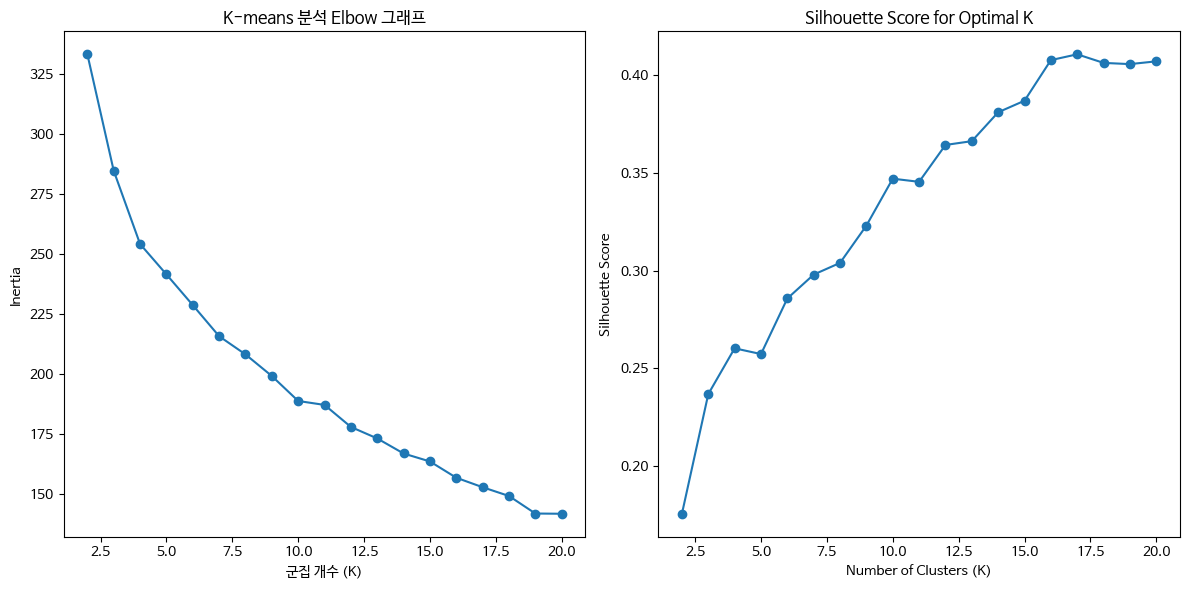

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tf_idf_data)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(tf_idf_data, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(tf_idf_data)

# 클러스터 결과를 데이터프레임에 추가
dp6_tmp['cluster'] = kmeans.labels_

- 군집별 갯수 확인

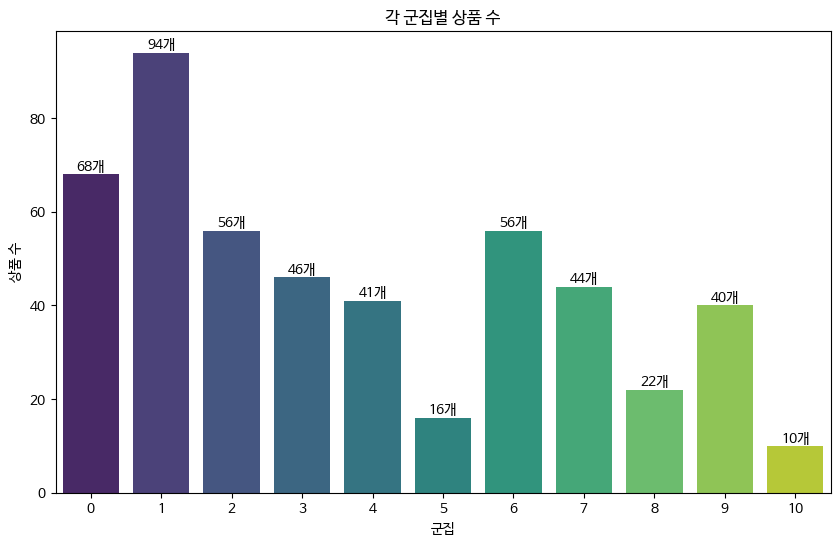

In [ ]:
df = dp6_tmp.groupby(['cluster']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster', y='상품명', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

- 각 군집의 중심 및 핵심 구분단어 확인

In [ ]:
cluster_centers = kmeans.cluster_centers_

# 각 군집의 중심에서 가장 가까운 단어 20개씩 추출
top_words_per_cluster = []
for center in cluster_centers:
    # 각 군집의 중심에서 가까운 10개 단어씩 가져오기
    top_word_indices = center.argsort()[-10:][::-1]

    # 해당 인덱스에 해당하는 단어들을 리스트에 추가
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_word_indices]
    top_words_per_cluster.append(top_words)

# 각 군집의 중심에서 가장 가까운 단어 출력
for i, top_words in enumerate(top_words_per_cluster):
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: 개월, 미만, 약정, 이상, 계약, 중도, 보통, 예금, 금리, 차등
Cluster 2: 가입, 이상, 가능, 인터넷, 전용, 스마트폰, 단리, 금액, 뱅킹, 복리
Cluster 3: 복리, 전용, 인터넷, 스마트폰, 해당, 가입, 뱅킹, 상품, 영업, 불가
Cluster 4: 방문, 영업, 단리, 해당, 상품, 가입, 전용, 창구, 한도, 연금
Cluster 5: 최소, 입금액, 이상, 금액, 전용, 복리, 인터넷, 스마트폰, 방문, 정기예금
Cluster 6: 보호, 사항, 예금자, 천만, 금융, 최고, 보호법, 원리금, 도외, 기타
Cluster 7: 단리, 전용, 인터넷, 스마트폰, 해당, 영업, 가입, 뱅킹, 상품, 보유
Cluster 8: 방문, 영업, 복리, 해당, 상품, 가입, 전용, 창구, 한도, 보통
Cluster 9: 제한, 소진, 전용, 스마트폰, 가입, 도금액, 인터넷, 채널, 조기, 단리
Cluster 10: 개월, 회전, 금리, 주기, 기간, 변동, 적용, 시점, 상품, 예금
Cluster 11: 중도, 지이, 적용, 우대금리, 시간, 인터넷, 창구, 전용, 스마트폰, 가능


- tabulate을 이용해 결과 확인

In [ ]:
def cutthe_text(strs):
    if isinstance(strs, str) and len(strs) > 30:
        return strs[:30]
    elif pd.isna(strs):
        return 'NaN'
    else:
        return strs

def decode_txt(strs):
    try:
        return strs.decode('utf-8')
    except:
        return strs

for i in range(12):
    print("cluster {}".format(i), '\n', tabulate(dp6_tmp[dp6_tmp.cluster == i].applymap(decode_txt)[['상품명', '금융회사', '문자열통합']].applymap(cutthe_text).head(20),
                                                  headers='keys', tablefmt='psql'))

cluster 0 
 +-----+-----------------+------------------+------------------------------------------------------+
|     | 상품명          | 금융회사         | 문자열통합                                           |
|-----+-----------------+------------------+------------------------------------------------------|
|  24 | 정기예금        | 오투저축은행     | 복리  영업점방문 중도해지이율                        |
|     |                 |                  | -1개월 미만: 보통예금                                |
|  25 | 정기예금        | 오투저축은행     | 단리  영업점방문 중도해지이율                        |
|     |                 |                  | -1개월 미만: 보통예금                                |
| 128 | 비대면 정기예금 | 오투저축은행     | 단리  인터넷스마트폰전용 중도해지이율                |
|     |                 |                  | -1개월 미만:                                         |
| 129 | 비대면 정기예금 | 오투저축은행     | 복리  인터넷스마트폰전용 중도해지이율                |
|     |                 |                  | -1개월 미만:                                         |
| 130 | E-정기예금      | 오투저축은행  

- Cluster 0 : 복리, 인터넷스마트폰전용 상품  
- Cluster 1 : 복리, 영업점 방문 상품
- Cluster 2 : 변동금리 or 회전정기예금 -> 금리변동 상품
- Cluster 3 : 중도해지이율 변동 존재
- Cluster 4 : 단리 - 영업점방문 상품
- Cluster 5 : 단리 - 인터넷스마트폰전용
- Cluster 6 : 진주저축은행 - 만65세 이상 비과세 종합저축
- Cluster 7 : ?
- Cluster 8 : 우대사항 혹은 특이사항이 존재하는것으로 보임.
- Cluster 9 : 최소금액기준 존재
- Cluster 10 : 예금자보호법 관련 사항으로 묶인듯


# [5] 전처리 + 수치형 데이터로 군집분석

In [ ]:
bank_info_df = pd.read_excel('/content/drive/MyDrive/ASAC_최종프로젝트/data/금융감독원데이터/(저축)은행_기초재무정보주요경영지표_230630기준.xlsx')


In [ ]:
dp6_tmp

,금융회사,상품명,세전이자율,세후이자율,최고우대금리,이자계산방식,우대조건,가입방법,만기후 이자율,기타유의사항,가입대상_최종,실질이자율,문자열통합,cluster
0,OSB저축은행,인터넷정기예금,4.50,3.81,4.5,복리,없음,인터넷스마트폰전용,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,0.966184,복리 인터넷스마트폰전용 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 ...,4
1,OSB저축은행,인터넷정기예금,4.50,3.81,4.5,단리,없음,인터넷스마트폰전용,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,1.015097,단리 인터넷스마트폰전용 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 ...,4
2,OSB저축은행,정기예금,4.50,3.81,4.5,복리,없음,영업점방문,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,0.966184,복리 영업점방문 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리...,4
3,OSB저축은행,정기예금,4.50,3.81,4.5,단리,없음,영업점방문,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,,1.015097,단리 영업점방문 -가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리...,4
4,조은저축은행,정기예금(서울본점),4.40,3.72,4.4,단리,없음,영업점방문,- 1개월이내 해지: 만기시 동일상품 동일계약기간의 신규약정금리\n'- 1개월초과 ...,없음,,0.916329,단리 영업점방문,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,엔에이치저축은행,비대면 정기예금,1.50,1.27,1.5,복리,없음,인터넷스마트폰전용,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,,-1.932367,복리 인터넷스마트폰전용,2
489,엔에이치저축은행,정기예금,1.40,1.18,1.4,단리,없음,영업점방문,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,,-2.024251,단리 영업점방문,3
490,엔에이치저축은행,정기예금,1.40,1.18,1.4,복리,없음,영업점방문,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,,-2.028986,복리 영업점방문,7
491,머스트삼일저축은행,자유적립예금,1.00,0.85,1.0,단리,없음,영업점방문,- 만기후 1개월 이내 : 1.2%\n- 만기후 1개월 초과 : 연0.2%,없음,,-2.413043,단리 영업점방문,3


## 5-1. 피쳐 엔지니어링

In [ ]:
dp6_num = dp6_tmp.copy()

- 최고_기본_diff :  최고우대금리 - 세전이자율

In [ ]:
dp6_num['최고_기본_diff'] = dp6_num['최고우대금리'] - dp6_num['세전이자율']

- 은행 구분

In [ ]:
bank_list = list(set(list(dp6_df['금융회사'].unique())))

# 저축은행(jb)와 일반은행(gb)로 분할한다.
jb = []
gb = []
ob = ['주식회사 카카오뱅크',  '토스뱅크 주식회사', '주식회사 케이뱅크']

for bank in bank_list:
    if '저축' in bank:
        jb.append(bank)
    else:
        gb.append(bank)

gb_not_ob = [bank for bank in gb if bank not in ob]

# 결과 출력
print("저축은행 리스트:", jb)
print("일반은행 리스트:", gb)
print("온라인은행 리스트:", ob)
print("온라인은행 제외 일반은행:", gb_not_ob)

저축은행 리스트: ['참저축은행', '다올저축은행', '키움저축은행', '평택상호저축은행', '하나저축은행', '인성저축은행', '아산저축은행', 'HB저축은행', '우리저축은행', '한화저축은행', '스마트저축은행', 'OK저축은행', '푸른저축은행', '모아저축은행', '진주저축은행', '동원제일저축은행', '웰컴저축은행', '엔에이치저축은행', '금화저축은행', '부림저축은행', '에스앤티저축은행', '대한저축은행', '대아상호저축은행', '안양저축은행', '삼호저축은행', '우리금융저축은행', '대신저축은행', '애큐온저축은행', '키움예스저축은행', '흥국저축은행', 'CK저축은행', '세람저축은행', '상상인저축은행', '유안타저축은행', '대백저축은행', '대명상호저축은행', '고려저축은행', '바로저축은행', '조은저축은행', 'OSB저축은행', '라온저축은행', '청주저축은행', '스카이저축은행', '센트럴저축은행', '더케이저축은행', '민국저축은행', '디비저축은행', '삼정저축은행', '대원저축은행', '예가람저축은행', 'DH저축은행', '신한저축은행', '솔브레인저축은행', 'JT저축은행', '상상인플러스저축은행', '안국저축은행', '오투저축은행', '유니온저축은행', 'JT친애저축은행', '오성저축은행', '국제저축은행', '동양저축은행', '영진저축은행', '남양저축은행', '조흥저축은행', '융창저축은행', 'MS저축은행', 'IBK저축은행', '인천저축은행', '스타저축은행', '한성저축은행', 'KB저축은행', 'SBI저축은행', '드림저축은행', '더블저축은행', '페퍼저축은행', '한국투자저축은행', '머스트삼일저축은행', 'BNK저축은행']
일반은행 리스트: ['토스뱅크 주식회사', '주식회사 카카오뱅크', '경남은행', '제주은행', '하나은행', '대구은행', '주식회사 케이뱅크', '신한은행', '우리은행', '한국산업은행', '중소기업은행', '부산은행', '광주은행', '농협은행주식회사', '국민은행', '수협

In [ ]:
def find_bank_type(df) :
    return df['금융회사'].apply(lambda x: '저축은행' if x in jb else ('온라인은행' if x in ob else ('일반은행' if x in gb_not_ob else None)))

In [ ]:
dp6_num['금융회사_종류'] =  find_bank_type(dp6_num)

- 은행 안정성 평가요소 결합

In [ ]:
bank_info_df

,구분,총자산,총부채,자기자본,당기순이익,BIS비율,여신비율,ROA,NIM,유형
0,경남은행,49459933,45969835,3490097,179759,14.63,0.37,0.60,1.90,은행
1,광주은행,28586391,26404717,2181674,153747,15.69,0.45,0.88,2.89,은행
2,국민은행,506394830,471771786,34623044,2318601,18.45,0.25,0.60,1.82,은행
3,농협은행주식회사,392192577,369969859,22222718,1512360,18.67,0.29,0.46,1.98,은행
4,대구은행,68723045,63714954,5008091,286461,17.65,0.58,0.56,2.04,은행
...,...,...,...,...,...,...,...,...,...,...
93,하나저축은행,2818231,2481709,336522,-1900,15.19,4.86,0.35,NaN,저축은행
94,한국투자저축은행,8611067,7403931,1207136,3129,16.30,4.35,1.04,NaN,저축은행
95,한성저축은행,397475,332131,65344,-1994,22.12,7.55,1.58,NaN,저축은행
96,한화저축은행,1754102,1579621,174481,4911,13.13,4.78,1.39,NaN,저축은행


In [ ]:
list_bank_info = bank_info_df.구분.unique()
list_dp_info = dp6_num.금융회사.unique()

In [ ]:
[value for value in list_bank_info if value not in list_dp_info]

['한국씨티은행',
 '대원상호저축은행',
 '디에이치저축은행',
 '비엔케이저축은행',
 '세람상호저축은행',
 '아이비케이저축은행',
 '에스비아이저축은행',
 '엠에스상호저축은행',
 '오에스비저축은행',
 '오케이저축은행',
 '유니온상호저축은행',
 '제이티저축은행',
 '제이티친애저축은행',
 '케이비저축은행',
 '푸른상호저축은행']

In [ ]:
[value for value in list_dp_info if value not in list_bank_info]

['OSB저축은행',
 'JT친애저축은행',
 'OK저축은행',
 'MS저축은행',
 'DH저축은행',
 'JT저축은행',
 'BNK저축은행',
 '푸른저축은행',
 'SBI저축은행',
 '유니온저축은행',
 'IBK저축은행',
 '세람저축은행',
 'KB저축은행',
 '대원저축은행']

In [ ]:
# 매핑 딕셔너리 생성
mapping_dict = {
    'OSB저축은행': '오에스비저축은행',
    'JT친애저축은행': '제이티친애저축은행',
    'OK저축은행': '오케이저축은행',
    'MS저축은행': '엠에스상호저축은행',
    'DH저축은행': '디에이치저축은행',
    'JT저축은행': '제이티저축은행',
    'BNK저축은행': '비엔케이저축은행',
    '푸른저축은행': '푸른상호저축은행',
    'SBI저축은행': '에스비아이저축은행',
    '유니온저축은행': '유니온상호저축은행',
    'IBK저축은행': '아이비케이저축은행',
    '세람저축은행': '세람상호저축은행',
    'KB저축은행': '케이비저축은행',
    '대원저축은행': '대원상호저축은행'
}

# '금융회사' 칼럼의 값 변경
tmp = dp6_num['금융회사'].map(mapping_dict).fillna(dp6_num['금융회사'])
dp6_num['금융회사'] = tmp

In [ ]:
bank_info_df.drop(['NIM','유형'], axis = 1, inplace = True)
bank_info_df.rename(columns = {'구분' : '금융회사'}, inplace = True)

In [ ]:
dp6_num = dp6_num.merge(bank_info_df, how = 'left', on = '금융회사')

- 총자산_부채 : 총부채 / 총자산

In [ ]:
dp6_num['총자산_부채'] = dp6_num['총부채'] / dp6_num['총자산']

- 총자산_자기자본 : 자기자본 / 총자산

In [ ]:
dp6_num['총자산_부채'] = dp6_num['자기자본'] / dp6_num['총자산']

- 은행종류별 평균과의 차이

In [ ]:
dp6_num['총자산_평균_diff'] = dp6_num['총자산'] - dp6_num.groupby('금융회사_종류')['총자산'].transform('mean')
dp6_num['총부채_평균_diff'] = dp6_num['총부채'] - dp6_num.groupby('금융회사_종류')['총부채'].transform('mean')
dp6_num['자기자본_평균_diff'] = dp6_num['자기자본'] - dp6_num.groupby('금융회사_종류')['자기자본'].transform('mean')
dp6_num['당기순이익_평균_diff'] = dp6_num['당기순이익'] - dp6_num.groupby('금융회사_종류')['당기순이익'].transform('mean')
dp6_num['BIS비율_평균_diff'] = dp6_num['BIS비율'] - dp6_num.groupby('금융회사_종류')['BIS비율'].transform('mean')
dp6_num['ROA_평균_diff'] = dp6_num['ROA'] - dp6_num.groupby('금융회사_종류')['ROA'].transform('mean')

In [ ]:
dp6_num

,금융회사,상품명,세전이자율,세후이자율,최고우대금리,이자계산방식,우대조건,가입방법,만기후 이자율,기타유의사항,...,BIS비율,여신비율,ROA,총자산_부채,총자산_평균_diff,총부채_평균_diff,자기자본_평균_diff,당기순이익_평균_diff,BIS비율_평균_diff,ROA_평균_diff
0,오에스비저축은행,인터넷정기예금,4.50,3.81,4.5,복리,없음,인터넷스마트폰전용,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,...,11.70,8.24,0.87,0.086043,1.180428e+06,1.118278e+06,6.215058e+04,-1.566434e+04,-4.556638,-0.208707
1,오에스비저축은행,인터넷정기예금,4.50,3.81,4.5,단리,없음,인터넷스마트폰전용,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,...,11.70,8.24,0.87,0.086043,1.180428e+06,1.118278e+06,6.215058e+04,-1.566434e+04,-4.556638,-0.208707
2,오에스비저축은행,정기예금,4.50,3.81,4.5,복리,없음,영업점방문,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,...,11.70,8.24,0.87,0.086043,1.180428e+06,1.118278e+06,6.215058e+04,-1.566434e+04,-4.556638,-0.208707
3,오에스비저축은행,정기예금,4.50,3.81,4.5,단리,없음,영업점방문,-만기후 1개월 이내 : 가입 시 약정금리와 만기 시 동일 상품의 금리 중 낮은 금...,-가입금액 : 10만원 이상\n-시장금리에 변동없는 최초 약정금리로 이자 수령,...,11.70,8.24,0.87,0.086043,1.180428e+06,1.118278e+06,6.215058e+04,-1.566434e+04,-4.556638,-0.208707
4,조은저축은행,정기예금(서울본점),4.40,3.72,4.4,단리,없음,영업점방문,- 1개월이내 해지: 만기시 동일상품 동일계약기간의 신규약정금리\n'- 1개월초과 ...,없음,...,16.12,7.01,1.16,0.125419,-1.323372e+06,-1.187582e+06,-1.357894e+05,5.489664e+03,-0.136638,0.081293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,엔에이치저축은행,비대면 정기예금,1.50,1.27,1.5,복리,없음,인터넷스마트폰전용,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,...,18.63,2.60,1.08,0.145076,6.137963e+05,4.598157e+05,1.539806e+05,3.003664e+03,2.373362,0.001293
489,엔에이치저축은행,정기예금,1.40,1.18,1.4,단리,없음,영업점방문,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,...,18.63,2.60,1.08,0.145076,6.137963e+05,4.598157e+05,1.539806e+05,3.003664e+03,2.373362,0.001293
490,엔에이치저축은행,정기예금,1.40,1.18,1.4,복리,없음,영업점방문,-1개월 이내: 지급 전일까지 해당 계좌의 약정금리와 기간별 적용금리 중 낮은 금리...,없음,...,18.63,2.60,1.08,0.145076,6.137963e+05,4.598157e+05,1.539806e+05,3.003664e+03,2.373362,0.001293
491,머스트삼일저축은행,자유적립예금,1.00,0.85,1.0,단리,없음,영업점방문,- 만기후 1개월 이내 : 1.2%\n- 만기후 1개월 초과 : 연0.2%,없음,...,10.55,2.40,1.72,0.078891,-1.526323e+06,-1.353851e+06,-1.724714e+05,4.846664e+03,-5.706638,0.641293


In [ ]:
dp6_num.columns

Index(['금융회사', '상품명', '세전이자율', '세후이자율', '최고우대금리', '이자계산방식', '우대조건', '가입방법',
       '만기후 이자율', '기타유의사항', '가입대상_최종', '실질이자율', '문자열통합', 'cluster',
       '최고_기본_diff', '금융회사_종류', '총자산', '총부채', '자기자본', '당기순이익', 'BIS비율', '여신비율',
       'ROA', '총자산_부채', '총자산_평균_diff', '총부채_평균_diff', '자기자본_평균_diff',
       '당기순이익_평균_diff', 'BIS비율_평균_diff', 'ROA_평균_diff'],
      dtype='object')

## 5-2. 전처리

- 라벨인코딩 : ['금융회사', '이자계산방식','가입방법', '금융회사_종류']

- 문자열 길이 : ['이자계산방식', '우대조건', '기타유의사항', '가입대상_최종', ]

- drop : ['상품명','문자열통합', 'cluster']

- 스케일링 : ['총자산', '총부채', '자기자본', '당기순이익', 'BIS비율', '여신비율','ROA']

In [ ]:
dp6_num_tmp = dp6_num.copy()

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# 1. 라벨 인코딩
label_cols = ['금융회사', '이자계산방식', '가입방법', '금융회사_종류']
label_encoder = LabelEncoder()
for col in label_cols:
    dp6_num_tmp[col] = label_encoder.fit_transform(dp6_num_tmp[col])

# 2. 일부 문자열은 문자열 길이로 대체한다
# str_len_cols = ['우대조건', '기타유의사항', '가입대상_최종', '만기후 이자율']
# for col in str_len_cols:
#     if dp6_num_tmp[col].dtype == 'O':  # Check if the column type is object (string)
#         dp6_num_tmp[col] = dp6_num_tmp[col].apply(len)

# 3. MinMaxScaler
#min_max_cols = ['총자산', '총부채', '자기자본', '당기순이익', 'BIS비율', '여신비율', 'ROA']
#scaler = MinMaxScaler()
#dp6_num_tmp[min_max_cols] = scaler.fit_transform(dp6_num_tmp[min_max_cols])

# 4. 불필요한 칼럼 제거
drop_cols = ['상품명', '문자열통합', 'cluster']
dp6_num_tmp = dp6_num_tmp.drop(drop_cols, axis=1)

In [ ]:
dp6_num_tmp.drop(['우대조건', '기타유의사항', '가입대상_최종', '만기후 이자율'], axis = 1, inplace = True)

In [ ]:
tf_idf_df = pd.DataFrame(tf_idf_data.toarray())
dp6_num_tmp = pd.concat([dp6_num_tmp, tf_idf_df], axis=1)

In [ ]:
dp6_num_tmp

,금융회사,세전이자율,세후이자율,최고우대금리,이자계산방식,가입방법,실질이자율,최고_기본_diff,금융회사_종류,총자산,...,261,262,263,264,265,266,267,268,269,270
0,58,4.50,3.81,4.5,1,3,0.966184,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58,4.50,3.81,4.5,0,3,1.015097,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,58,4.50,3.81,4.5,1,0,0.966184,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58,4.50,3.81,4.5,0,0,1.015097,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74,4.40,3.72,4.4,0,0,0.916329,0.00,2,444272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,53,1.50,1.27,1.5,1,3,-1.932367,0.00,2,2381440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489,53,1.40,1.18,1.4,0,0,-2.024251,0.00,2,2381440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490,53,1.40,1.18,1.4,1,0,-2.028986,0.00,2,2381440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,26,1.00,0.85,1.0,0,0,-2.413043,0.00,2,241321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dp6_num_tmp.columns = dp6_num_tmp.columns.astype(str)

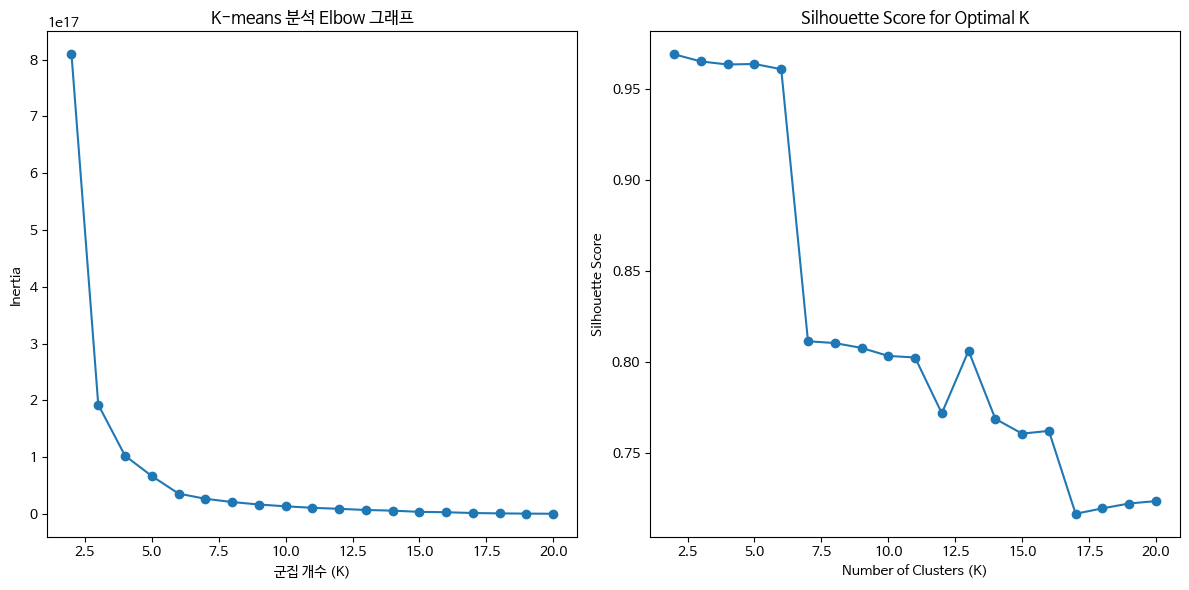

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dp6_num_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(dp6_num_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
dp6_num_tmp

,금융회사,세전이자율,세후이자율,최고우대금리,이자계산방식,가입방법,실질이자율,최고_기본_diff,금융회사_종류,총자산,...,261,262,263,264,265,266,267,268,269,270
0,58,4.50,3.81,4.5,1,3,0.966184,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58,4.50,3.81,4.5,0,3,1.015097,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,58,4.50,3.81,4.5,1,0,0.966184,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58,4.50,3.81,4.5,0,0,1.015097,0.00,2,2948072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74,4.40,3.72,4.4,0,0,0.916329,0.00,2,444272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,53,1.50,1.27,1.5,1,3,-1.932367,0.00,2,2381440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489,53,1.40,1.18,1.4,0,0,-2.024251,0.00,2,2381440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490,53,1.40,1.18,1.4,1,0,-2.028986,0.00,2,2381440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,26,1.00,0.85,1.0,0,0,-2.413043,0.00,2,241321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(dp6_num_tmp)

# 클러스터 결과를 데이터프레임에 추가
dp6_num_tmp['cluster'] = kmeans.labels_

In [ ]:
dp6_num_tmp['상품명'] = dp6_tmp['상품명']
dp6_num_tmp['은행명'] = dp6_tmp['금융회사']

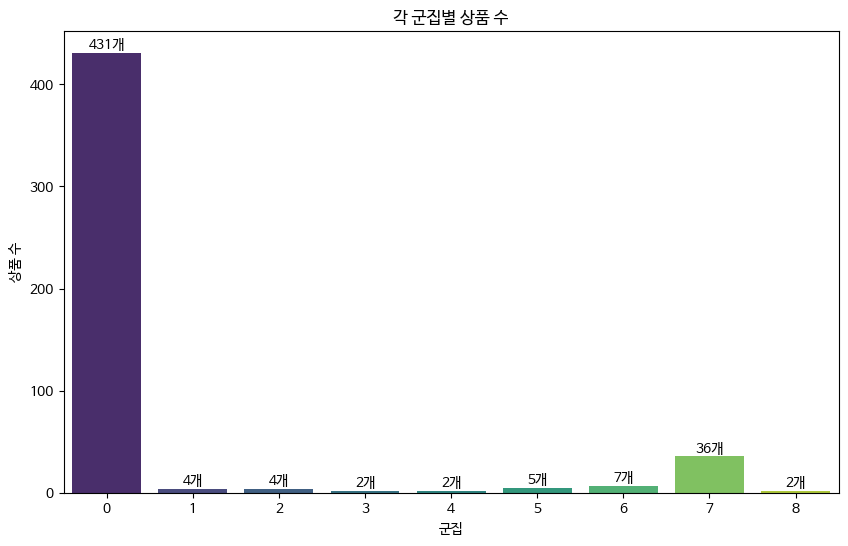

In [ ]:
df = dp6_num_tmp.groupby(['cluster']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster', y='상품명', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()